In [2]:
import cv2  
import numpy as np
import matplotlib.pyplot as plt

Máximo de píxeles blancos en filas: 0.4296875
Filas con >= 90% del máximo: [  6  12  15  20  21  88 100]
Valores de esas filas: [0.39648438 0.4296875  0.3984375  0.390625   0.39257812 0.38867188
 0.4140625 ]


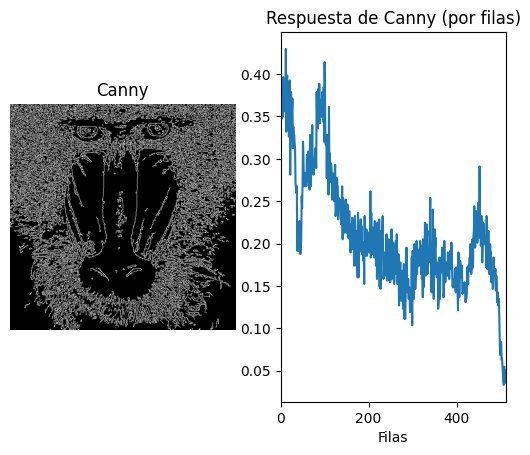

In [3]:
# Tarea 1

img = cv2.imread('mandril.jpg')
#Obtenemos la imagen en escala de grises
gris = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
#Obtenemos los contornos
canny = cv2.Canny(gris, 100, 200)

# Cuenta el número de píxeles blancos (255) por fila
# reduce con dim=1 porque queremos reducir a lo largo de las columnas
row_counts = cv2.reduce(canny, 1, cv2.REDUCE_SUM, dtype=cv2.CV_32SC1)

# Normalizamos en base al número de columnas y al valor máximo (255)
rows = row_counts[:, 0] / (255 * canny.shape[1])

# Determinamos el valor máximo de píxeles blancos por fila
maxfil = np.max(rows)

# Buscamos las filas con número de píxeles blancos >= 0.90 * maxfil
threshold = 0.90 * maxfil
filas_destacadas = np.where(rows >= threshold)[0]

# Muestra resultados
print("Máximo de píxeles blancos en filas:", maxfil)
print("Filas con >= 90% del máximo:", filas_destacadas)
print("Valores de esas filas:", rows[filas_destacadas])

# Gráfico
plt.figure()
plt.subplot(1, 2, 1)
plt.axis("off")
plt.title("Canny")
plt.imshow(canny, cmap='gray')

plt.subplot(1, 2, 2)
plt.title("Respuesta de Canny (por filas)")
plt.xlabel("Filas")
plt.ylabel("% píxeles")
plt.plot(rows)
plt.xlim([0, canny.shape[0]])
plt.show()



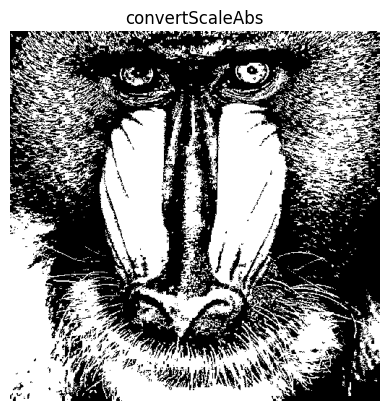

In [ ]:
# Tarea 2 -> aplicar sobel convertido a 8 bits, aplicar umbralizado
# Suavizamos la imagen
gris_suavizado = cv2.GaussianBlur(gris, (3, 3), 0)

# Aplicamos Sobel
sobelX = cv2.Sobel(gris_suavizado, cv2.CV_64F, 1, 0)  # x
sobelY = cv2.Sobel(gris_suavizado, cv2.CV_64F, 0, 1)  # y
sobel = cv2.add(sobelX, sobelY)

# Convertimos a 8 bits
sobel8 = cv2.convertScaleAbs(sobel)

# Mostramos el resultado
plt.figure()
plt.axis("off")
plt.title('convertScaleAbs')
plt.imshow(sobel8, cmap='gray') 


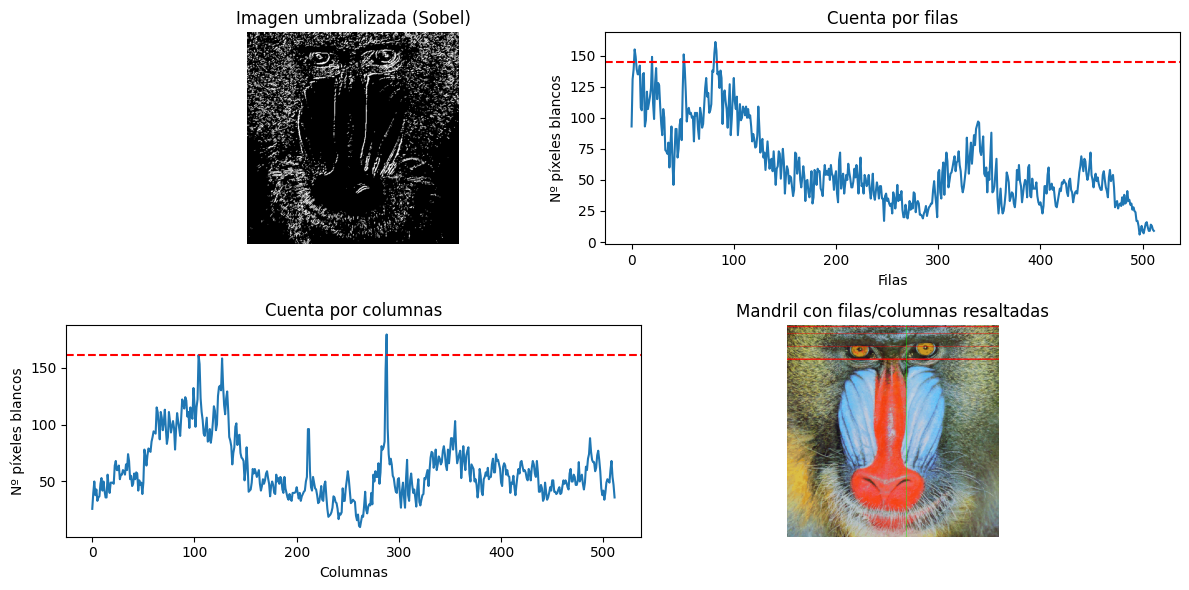

In [14]:
# Ahora umbralizamos la imagen
umbral = 130
_, imagenUmbralizada = cv2.threshold(sobel8, umbral, 255, cv2.THRESH_BINARY)

# Conteo por filas
row_counts = cv2.reduce(imagenUmbralizada, 1, cv2.REDUCE_SUM, dtype=cv2.CV_32SC1)
rows = row_counts[:, 0] / 255  # número de píxeles blancos por fila

# Conteo por columnas
col_counts = cv2.reduce(imagenUmbralizada, 0, cv2.REDUCE_SUM, dtype=cv2.CV_32SC1)
cols = col_counts[0, :] / 255  # número de píxeles blancos por columna

# Valores máximos
max_row = np.max(rows)
max_col = np.max(cols)

# Filas y columnas con valor >= 90% del máximo
rows_sel = np.where(rows >= 0.9 * max_row)[0]
cols_sel = np.where(cols >= 0.9 * max_col)[0]

# Cargar mandril (imagen original)
mandril = cv2.imread("mandril.jpg", cv2.IMREAD_COLOR)
mandril_rgb = cv2.cvtColor(mandril, cv2.COLOR_BGR2RGB)

# Dibujar líneas sobre mandril
mandril_marked = mandril_rgb.copy()
for r in rows_sel:
    cv2.line(mandril_marked, (0, r), (mandril.shape[1], r), (255, 0, 0), 1)
for c in cols_sel:
    cv2.line(mandril_marked, (c, 0), (c, mandril.shape[0]), (0, 255, 0), 1)

# Mostrar resultados
plt.figure(figsize=(12, 6))

plt.subplot(2, 2, 1)
plt.axis("off")
plt.title("Imagen umbralizada (Sobel)")
plt.imshow(imagenUmbralizada, cmap='gray')

plt.subplot(2, 2, 2)
plt.title("Cuenta por filas")
plt.plot(rows)
plt.axhline(0.9*max_row, color='r', linestyle='--')
plt.xlabel("Filas")
plt.ylabel("Nº píxeles blancos")

plt.subplot(2, 2, 3)
plt.title("Cuenta por columnas")
plt.plot(cols)
plt.axhline(0.9*max_col, color='r', linestyle='--')
plt.xlabel("Columnas")
plt.ylabel("Nº píxeles blancos")

plt.subplot(2, 2, 4)
plt.axis("off")
plt.title("Mandril con filas/columnas resaltadas")
plt.imshow(mandril_marked)

plt.tight_layout()
plt.show()


In [ ]:

# Tarea 3
vid = cv2.VideoCapture(0)

# Inicializamos sustractor de fondo
eliminadorFondo = cv2.createBackgroundSubtractorMOG2(history=100, varThreshold=50, detectShadows=True)

modo = 0  # 0=original, 1=fondo, 2=gris, 3=canny

while True:
    ret, frame = vid.read()
    if not ret:
        break

    # Efecto espejo
    frame = cv2.flip(frame, 1)

    if modo == 0:  # Modo original
        salida = frame

    elif modo == 1:  # Sustracción de fondo
        salida = eliminadorFondo.apply(frame)

    elif modo == 2:  # Escala de grises
        salida = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

    elif modo == 3:  # Detección de bordes
        gris = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        salida = cv2.Canny(gris, 100, 200)

    # Muestra resultado según el modo
    cv2.imshow("Demostrador", salida)

    # Captura teclas
    key = cv2.waitKey(20) & 0xFF
    if key == 27:  # ESC para salir
        break
    elif key == ord('m'):  # Tecla m para cambiar modo
        modo = (modo + 1) % 4

# Libera recursos
vid.release()
cv2.destroyAllWindows()
cv2.waitKey(1)


2025-09-27 17:01:47.779 python[1320:11328] WARNING: AVCaptureDeviceTypeExternal is deprecated for Continuity Cameras. Please use AVCaptureDeviceTypeContinuityCamera and add NSCameraUseContinuityCameraDeviceType to your Info.plist.


-1

In [ ]:
cap = cv2.VideoCapture(0)

# Parámetros de la pelota
x, y = 300, 200
vx, vy = 5, 4
radius = 20
color = (0,0,0)

# Estos parametros cambiaran tras el primer frame
width, height = 640, 480

while True:
    ret, frame = cap.read()
    if not ret:
        break

    frame = cv2.flip(frame, 1)
    height, width = frame.shape[:2]

    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    blur = cv2.GaussianBlur(gray, (7,7), 0)
    edges = cv2.Canny(blur, 50, 150)

    # Rebote contra los bordes de la ventana
    if x - radius <= 0 or x + radius >= width:
        vx = -vx + np.random.randint(-2, 3)
    if y - radius <= 0 or y + radius >= height:
        vy = -vy + np.random.randint(-2, 3)

    # Rebote si la pelota toca los bordes detectados por Canny
    x1, y1 = max(0, x-radius), max(0, y-radius)
    x2, y2 = min(width, x+radius), min(height, y+radius)
    roi = edges[y1:y2, x1:x2]
    if cv2.countNonZero(roi) > 0:
        vx = -vx + np.random.randint(-2, 3)
        vy = -vy + np.random.randint(-2, 3)

    # Actualiza posición
    x += vx
    y += vy

    # Dibuja la pelota
    cv2.circle(frame, (x, y), radius, color, -1)

    cv2.imshow("Pelota interactiva con Canny", frame)
    cv2.imshow("Bordes detectados", edges)

    if cv2.waitKey(30) & 0xFF == 27:
        break

cap.release()
cv2.destroyAllWindows()
cv2.waitKey(1)


2025-09-27 18:07:15.821 python[3650:85509] WARNING: AVCaptureDeviceTypeExternal is deprecated for Continuity Cameras. Please use AVCaptureDeviceTypeContinuityCamera and add NSCameraUseContinuityCameraDeviceType to your Info.plist.


-1